In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import torchvision.transforms as transforms

dataset_path = '/content/drive/MyDrive/Colab Notebooks/dl/leafs-dataset'

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
from collections import Counter
from random import sample
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class LeafHealthDataset(Dataset):
    def __init__(self, root_dir, leaf_species_name, transform=None, subset=None):
        self.root_dir = root_dir
        self.leaf_species_name = leaf_species_name
        self.transform = transform
        self.subset = subset
        self.samples, self.category_counts, self.health_to_idx = self._load_samples()

    def _load_samples(self):
        samples = []
        health_counts = Counter()

        for folder_name in filter(lambda x: x.startswith(self.leaf_species_name + '___'), os.listdir(self.root_dir)):
            health_label = folder_name.split('___')[1]
            folder_path = os.path.join(self.root_dir, folder_name)

            all_samples = []
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                all_samples.append((img_path, health_label))

            if self.subset and len(all_samples) > self.subset:
                sampled_images = sample(all_samples, self.subset)
            else:
                sampled_images = all_samples

            samples.extend(sampled_images)
            health_counts[health_label] += len(sampled_images)

        health_to_idx = {health: idx for idx, health in enumerate(health_counts)}
        return samples, health_counts, health_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, health_label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        one_hot = torch.zeros(len(self.health_to_idx))
        one_hot[self.health_to_idx[health_label]] = 1

        return img, health_label, one_hot

    def get_health_to_idx(self):
        return self.health_to_idx

    def get_category_counts(self):
      return self.category_counts

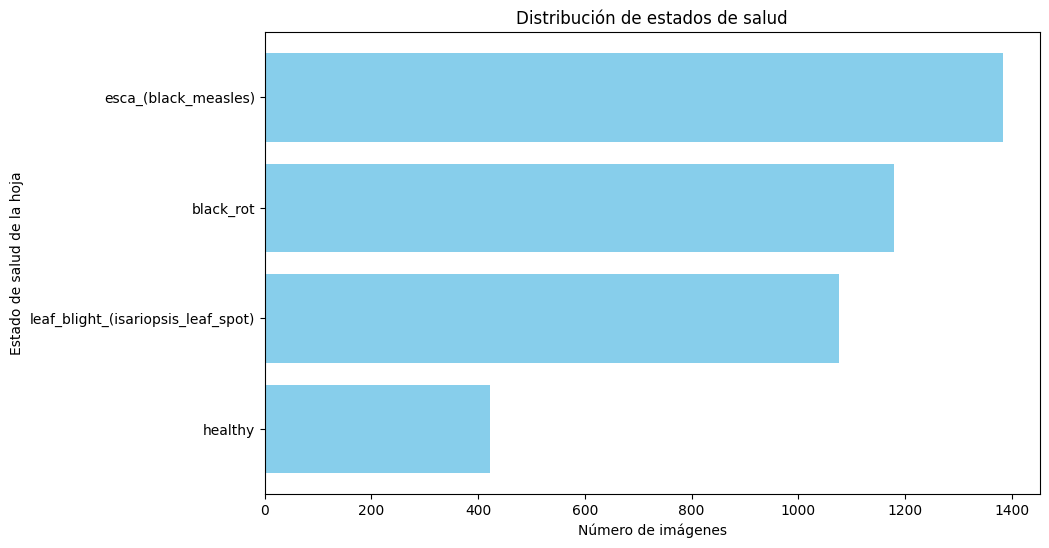

In [5]:
import matplotlib.pyplot as plt

leafhealth_dataset = LeafHealthDataset(root_dir=dataset_path, leaf_species_name='grape', transform=transformations, subset=None)
leafhealth_counts = leafhealth_dataset.get_category_counts()

sorted_leafhealth_counts = {k: v for k, v in sorted(leafhealth_counts.items(), key=lambda item: item[1])}

leafhealth_statuses = list(sorted_leafhealth_counts.keys())
leafhealth_statuses_number = list(sorted_leafhealth_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(leafhealth_statuses, leafhealth_statuses_number, color='skyblue')
plt.ylabel('Estado de salud de la hoja')
plt.xlabel('Número de imágenes')
plt.title('Distribución de estados de salud')
plt.show()

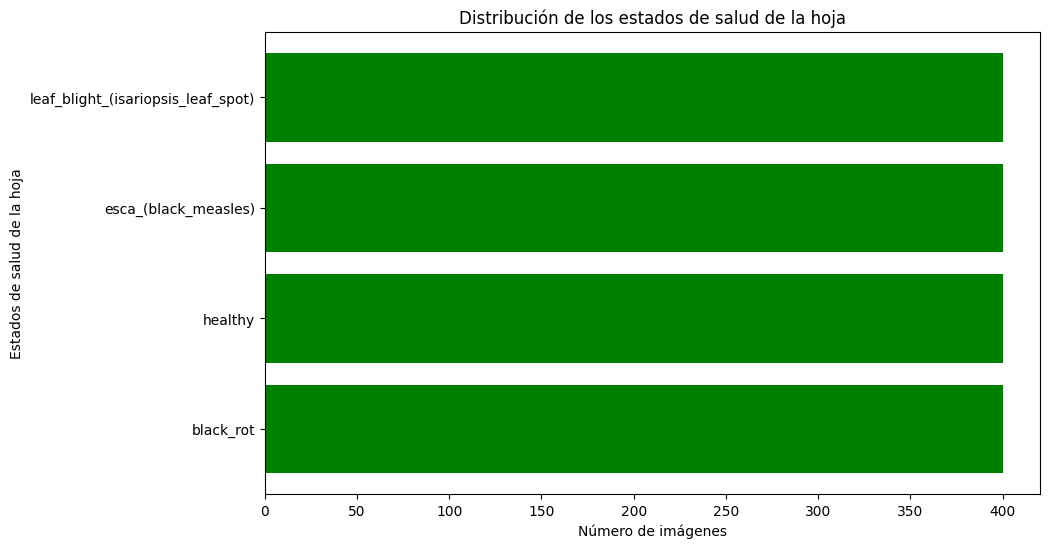

In [6]:
sample_len = 400

balanced_dataset = LeafHealthDataset(root_dir=dataset_path, leaf_species_name='grape', transform=transformations, subset=int(sample_len))
balanced_counts = balanced_dataset.get_category_counts()

balanced_catorgies = list(balanced_counts.keys())
balanceditems_by_category = list(balanced_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(balanced_catorgies, balanceditems_by_category, color='green')
plt.ylabel('Estados de salud de la hoja')
plt.xlabel('Número de imágenes')
plt.title('Distribución de los estados de salud de la hoja')
plt.show()

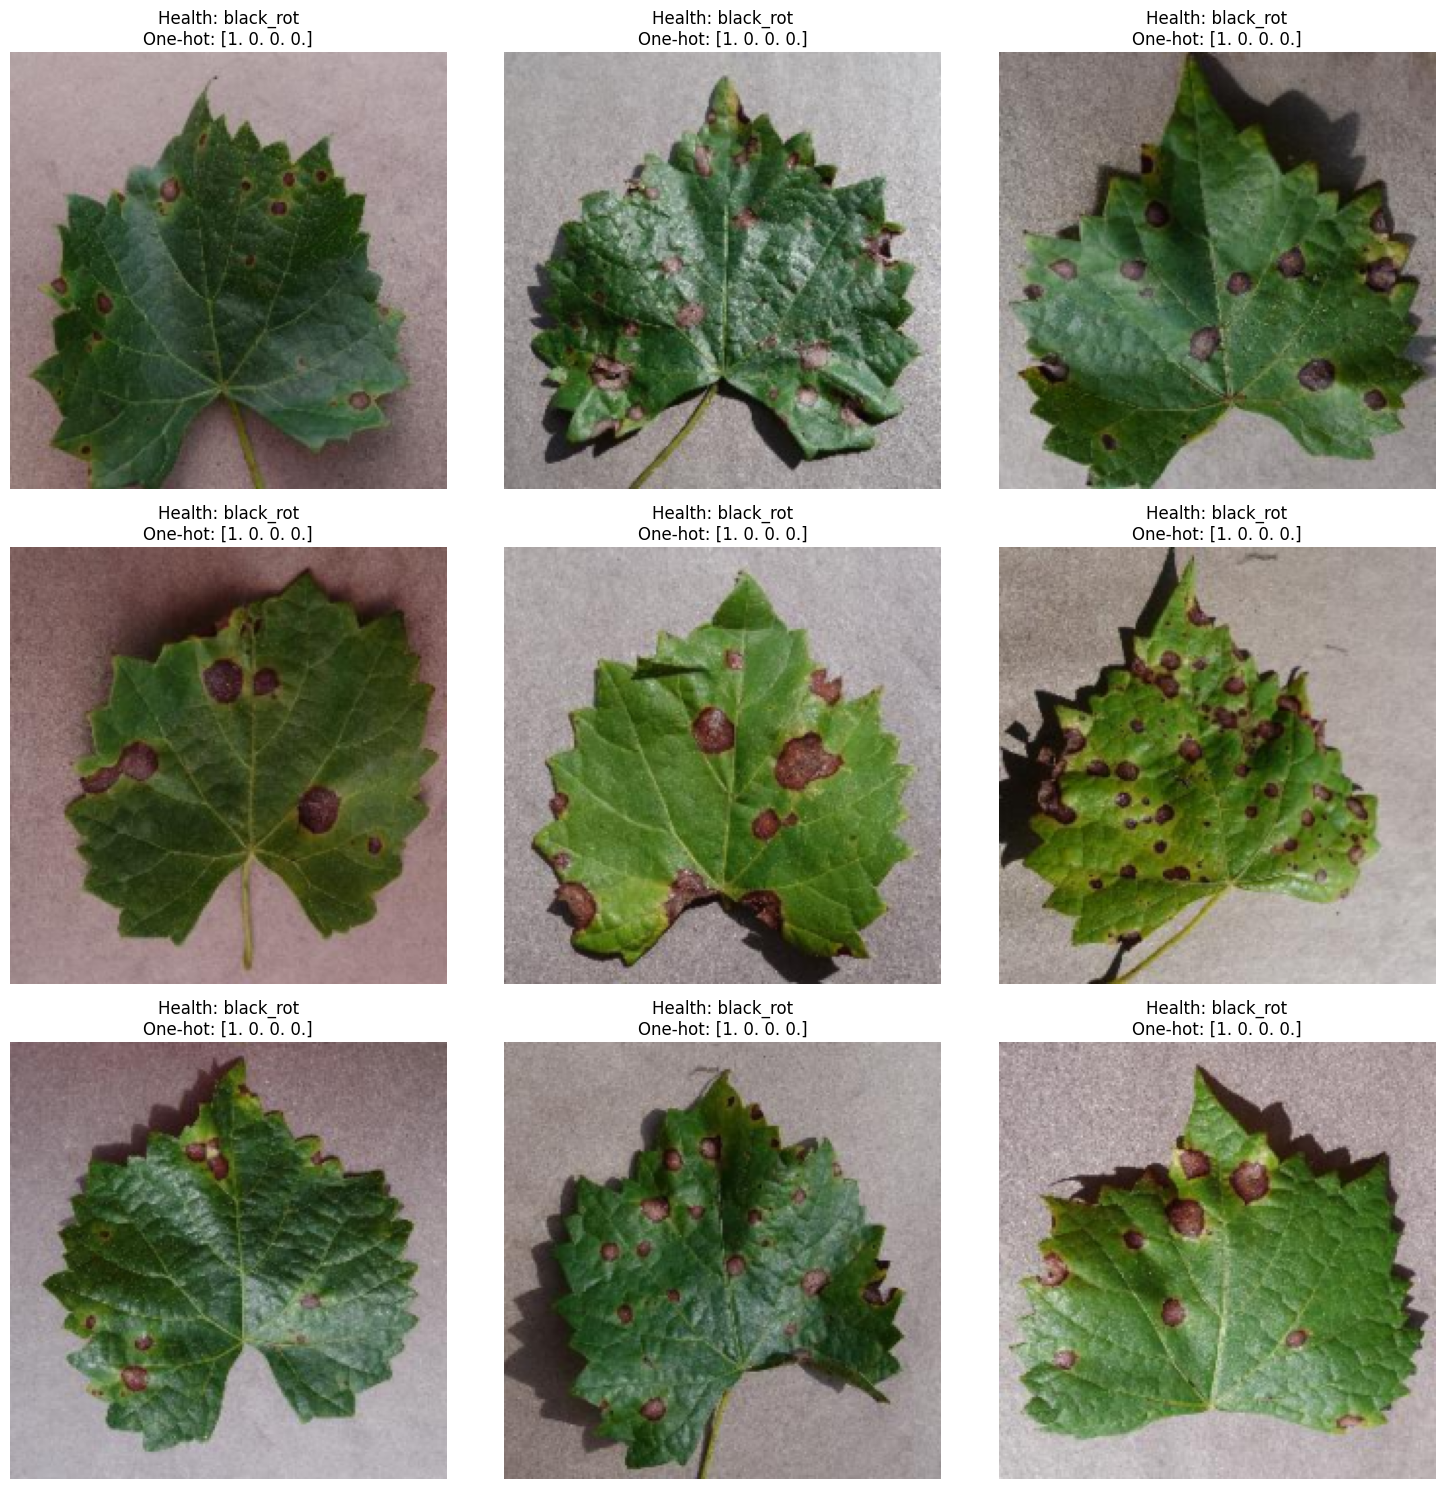

In [7]:
import matplotlib.pyplot as plt
from PIL import Image


selected_samples = []

for img, health_label, one_hot in balanced_dataset:
    selected_samples.append((img, health_label, one_hot))
    if len(selected_samples) == 9:
        break

num_samples = len(selected_samples)
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, (img, health_label, one_hot) in enumerate(selected_samples):
    if img.shape[0] == 3:  # Verificar si el tensor de imagen es CxHxW
        img = img.permute(1, 2, 0)  # Convertir a HxWxC para la visualización
    axes[i].imshow(img)
    axes[i].set_title(f"Health: {health_label}\nOne-hot: {one_hot.numpy()}")
    axes[i].axis('off')

for ax in axes[len(selected_samples):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
total_size = len(balanced_dataset)

train_size = int(0.80 * total_size)
val_size = int(total_size - train_size)
test_size = int(0.02 * val_size)
val_size = val_size - test_size

print(f'Total: {total_size}, Entrenamiento: {train_size}, Validacion: {val_size}, Test: {test_size}')

Total: 1600, Entrenamiento: 1280, Validacion: 314, Test: 6


In [9]:
from torch.utils.data import random_split
train_dataset, val_dataset, test_dataset = random_split(balanced_dataset, [train_size, val_size, test_size])

In [10]:
from torch.utils.data import DataLoader

batch_size = 40

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class MyResNet18_LeafHealthClassification(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(MyResNet18_LeafHealthClassification, self).__init__()

        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def my_resnet18_leafHealthClassification(num_classes):
    return MyResNet18_LeafHealthClassification(BasicBlock, [2, 2, 2], num_classes)


In [12]:
from torchsummary import summary

def my_resnet18_grapeHealthClassification():
  return my_resnet18_leafHealthClassification(num_classes=4)

summary(my_resnet18_grapeHealthClassification().to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,704
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,216
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              ReLU-7           [-1, 32, 56, 56]               0
            Conv2d-8           [-1, 32, 56, 56]           9,216
       BatchNorm2d-9           [-1, 32, 56, 56]              64
             ReLU-10           [-1, 32, 56, 56]               0
       BasicBlock-11           [-1, 32, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           9,216
      BatchNorm2d-13           [-1, 32, 56, 56]              64
             ReLU-14           [-1, 32,

In [13]:
def fit(model, train_loader, val_loader, epochs, optimizer, loss_fn, checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float('inf')

    print(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, _, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, _, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += loss_fn(outputs, labels).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model improved and saved to {checkpoint_path}')

In [14]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

health_model = my_resnet18_grapeHealthClassification().to('cuda')
optimizer = optim.Adam(health_model.parameters(), lr=0.001)
loss_fn = F.cross_entropy
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model"

fit(health_model, train_loader, val_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn, checkpoint_path=checkpoint_path)

cuda
Epoch 1/10, Training Loss: 0.6098
Epoch 1/10, Validation Loss: 3.6788
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model
Epoch 2/10, Training Loss: 0.3934
Epoch 2/10, Validation Loss: 1.3416
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model
Epoch 3/10, Training Loss: 0.3849
Epoch 3/10, Validation Loss: 3.7101
Epoch 4/10, Training Loss: 0.3299
Epoch 4/10, Validation Loss: 0.8272
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model
Epoch 5/10, Training Loss: 0.3336
Epoch 5/10, Validation Loss: 1.0259
Epoch 6/10, Training Loss: 0.2607
Epoch 6/10, Validation Loss: 0.5073
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model
Epoch 7/10, Training Loss: 0.2809
Epoch 7/10, Validation Loss: 2.1095
Epoch 8/10, Training Loss: 0.2788
Epoch 8/10, Validation Loss: 2.2278
Epoch 9/10, Training Loss: 0.2354
Epoch 9/10, Validation Lo

In [15]:
def test(model, test_loader, loss_fn):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, _, targets in test_loader:

            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Convertir los logits a probabilidades y obtener la clase predicha
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(probabilities, 1)
            _, targets = torch.max(targets, 1)

            print("Outputs shape:", outputs.shape)
            print("Probabilities shape:", probabilities.shape)
            print("Predicted shape:", predicted.shape)
            print("Targets shape:", targets.shape)

            # Contar las predicciones correctas
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calcular la precisión total
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)  # Calcular la pérdida media del test set (opcional)
    return avg_loss, accuracy

In [16]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/dl/leafs_model/grape_model"
model = my_resnet18_grapeHealthClassification()
model.load_state_dict(torch.load(checkpoint_path))
model.to('cuda')

MyResNet18_LeafHealthClassification(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [17]:
test_loss, test_accuracy = test(model, test_loader, loss_fn)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Outputs shape: torch.Size([6, 4])
Probabilities shape: torch.Size([6, 4])
Predicted shape: torch.Size([6])
Targets shape: torch.Size([6])
Test Loss: 0.2614, Test Accuracy: 1.00


In [18]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def classify_leaf_health(image_path, model, classes):
    transformations = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    transformed_image = transformations(image).unsqueeze(0).to('cuda')

    model.eval()
    with torch.no_grad():
        output = model(transformed_image)

    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, pred_idx = torch.max(probabilities, 1)

    predicted_species = classes[pred_idx.item()]

    return predicted_species

In [19]:
leaf_example_file = 'grape___black_rot/1a603016-c88a-4227-865f-575ddf5eddd2___FAM_B.Rot 0464.JPG'
file_path = os.path.join(dataset_path, leaf_example_file)
classes = {v: k for k, v in balanced_dataset.get_health_to_idx().items()}

print(classes)

health_status = classify_leaf_health(file_path, model, classes)
print(health_status)

{0: 'black_rot', 1: 'healthy', 2: 'esca_(black_measles)', 3: 'leaf_blight_(isariopsis_leaf_spot)'}
black_rot
